In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import timm
import torch
from tqdm.auto import tqdm

import cv2
import pandas as pd 
from config import cfg
from utils import CLIPDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models import (CLIPModel, 
                    TextEncoder, 
                    ImageEncoder)



from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
# path to validation dataframe from Flicker dataset.
# This dataframe is logged in log dir.
VAL_DATAFRAME_PATH = "/home/ml/rajan/scratch/clip/log/June06-13-15-15-17/valid.csv"
# path to model
MODEL_PATH = "/home/ml/rajan/scratch/clip/log/June06-13-18-44-30/Epoch-4_Model.pt"

<p align="center" width="100%">
    Some Helper Methods.<br>

</p>

In [3]:
def get_transforms(mode="train"):
    
    img_enc = ImageEncoder()

    data_config = img_enc.data_config
    
    if mode=="train":
    
        transforms = timm.data.create_transform(**data_config, is_training=True)
        return transforms
    else:
        
        transforms = timm.data.create_transform(**data_config, is_training=False)
        return transforms


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        image_filenames = dataframe["image"].values,
        captions= dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
        image_path=cfg.paths.images_path
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.dataloader.batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

<p align="center" width="100%">
    Text to Image<br>

</p>

In [4]:
def get_image_embeddings(valid_df, model_path):
    text_encoder = TextEncoder()
    tokenizer = text_encoder.tokenizer

    
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(cfg.train.device)
    model.load_state_dict(torch.load(model_path, map_location=cfg.train.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(cfg.train.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)



def find_matches(model, image_embeddings, query, image_filenames, n=9):
    text_encoder = TextEncoder()
    tokenizer = text_encoder.tokenizer
    encoded_query = tokenizer([query])
    
    batch = {
        key: torch.tensor(values).to(cfg.train.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(batch)
        text_embeddings = model.text_projection(text_features)
        
    

    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{cfg.paths.images_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    fig.suptitle(query)
    plt.show()
    
valid_df = pd.read_csv(VAL_DATAFRAME_PATH)
model, image_embeddings = get_image_embeddings(valid_df, MODEL_PATH)

  0%|          | 0/994 [00:00<?, ?it/s]

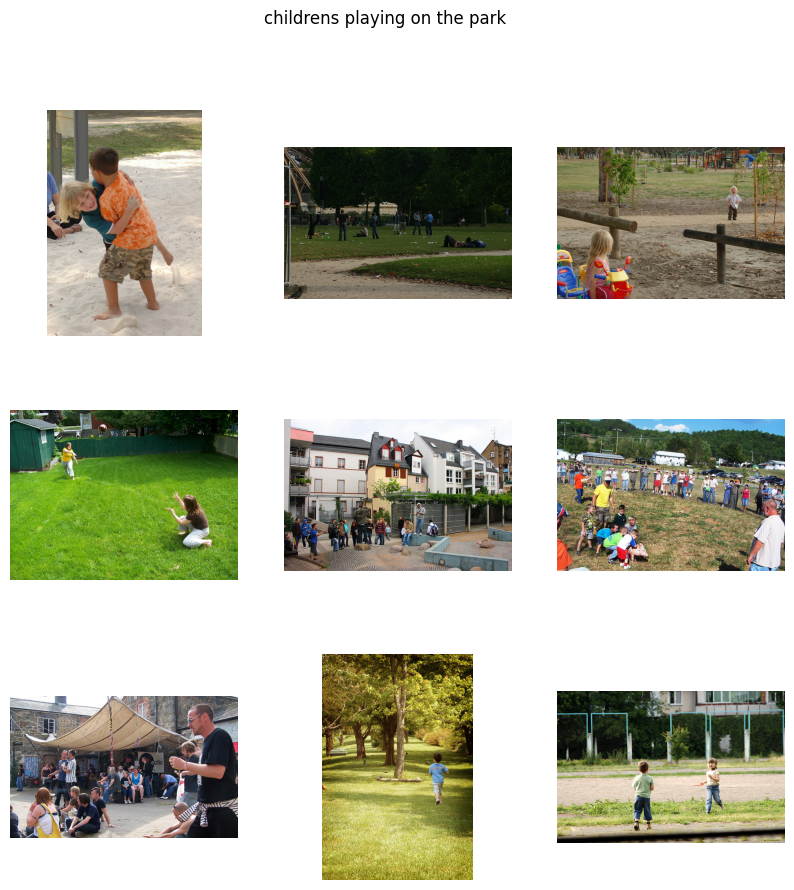

In [5]:
find_matches(model, 
             image_embeddings,
             query="childrens playing on the park",
             image_filenames=valid_df['image'].values,
             n=9)

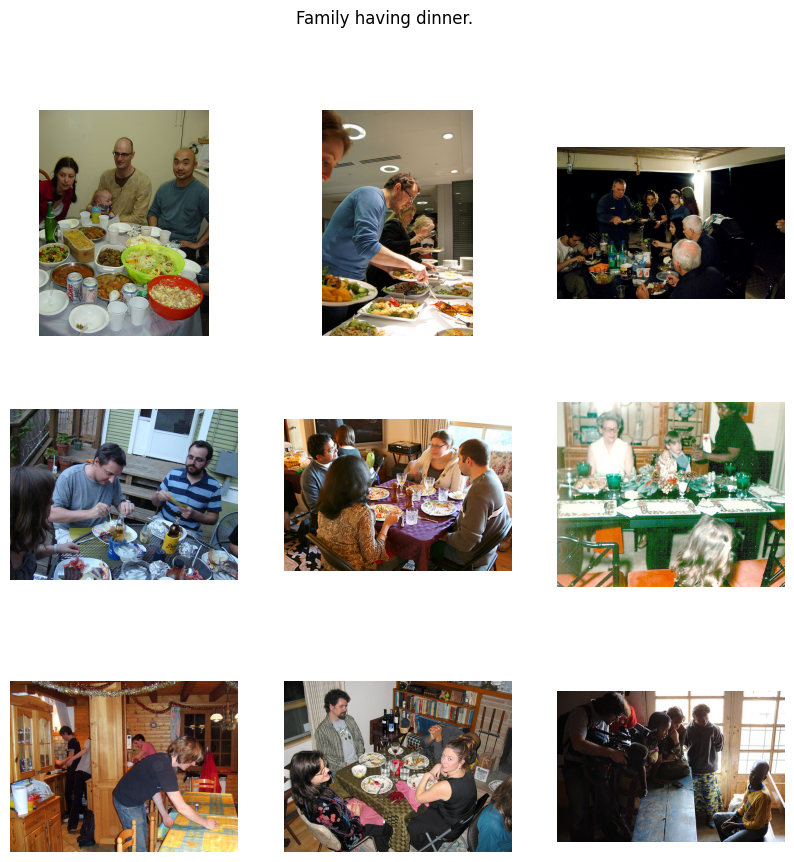

In [6]:
find_matches(model, 
             image_embeddings,
             query="Family having dinner.",
             image_filenames=valid_df['image'].values,
             n=9)

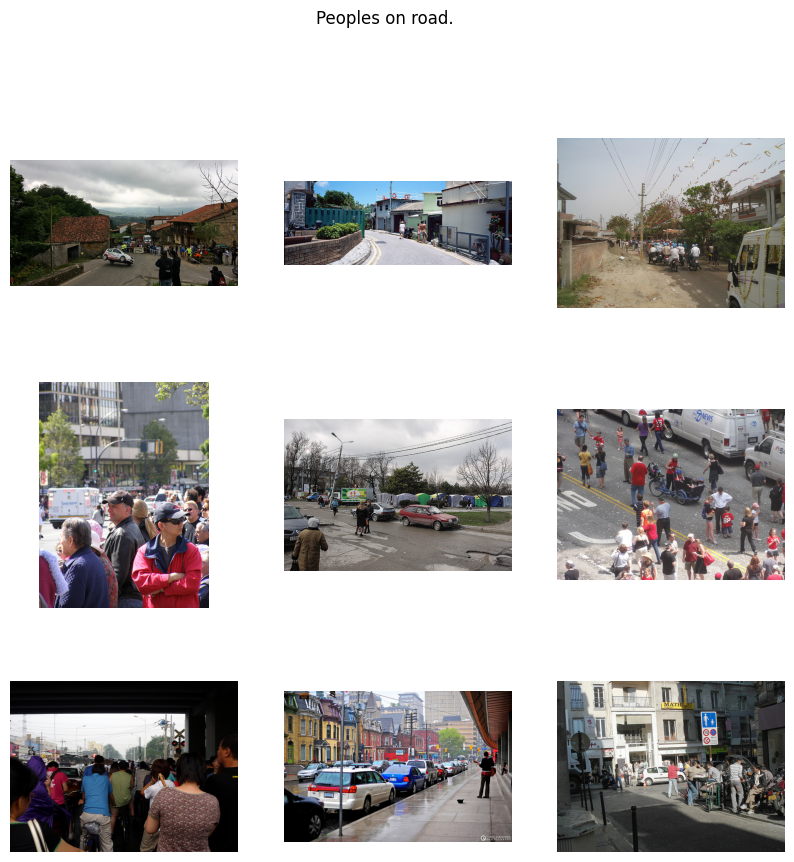

In [7]:
find_matches(model, 
             image_embeddings,
             query="Peoples on road.",
             image_filenames=valid_df['image'].values,
             n=9) 

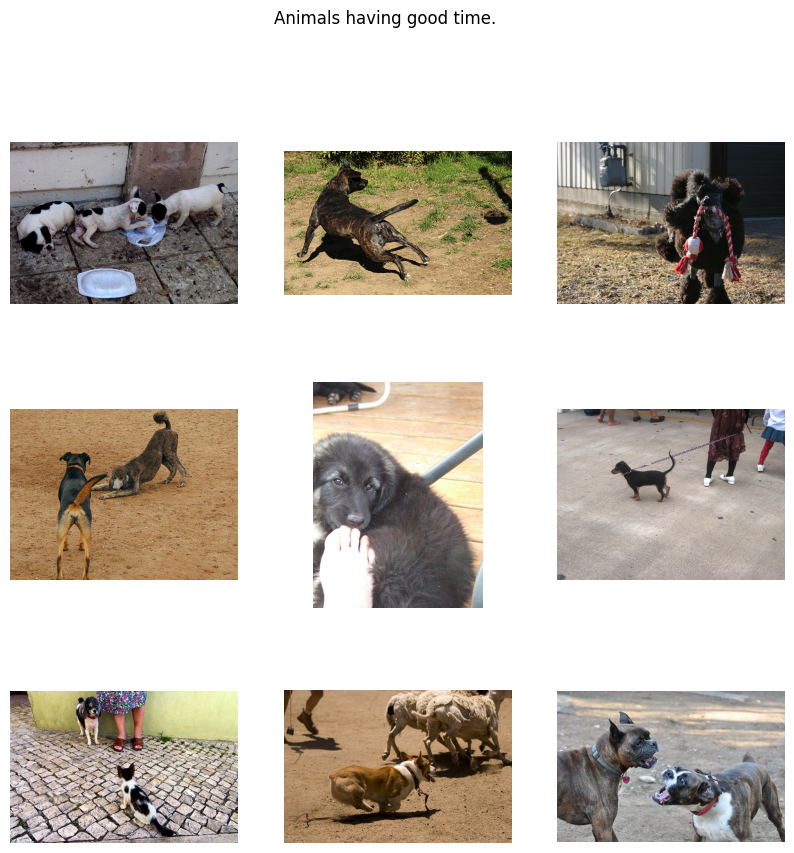

In [8]:
find_matches(model, 
             image_embeddings,
             query="Animals having good time.",
             image_filenames=valid_df['image'].values,
             n=9) 

<p align="center" width="100%">
    Image to Text<br>

</p>

In [9]:
def get_text_embedding(valid_df, model_path):
    model = CLIPModel().to(cfg.train.device)
    model.load_state_dict(torch.load(model_path, map_location=cfg.train.device))
    model.eval()
    
    
    text_enc = TextEncoder()
    text_enc = text_enc.to(cfg.train.device)
    tokenizer = text_enc.get_tokenzier()
    
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    print("Done Valid Loder \nConverting Now..")
    
    
    val_text_embedding = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            keys_to_keep = ['input_ids', 'token_type_ids', 'attention_mask']
            batch = {k: v.to(cfg.train.device) for k, v in batch.items() if k in keys_to_keep}  # Move batch to device
            text_features = model.text_encoder(batch)
            text_embeddings = model.text_projection(text_features)
            val_text_embedding.append(text_embeddings)
    return model, torch.cat(val_text_embedding)



def find_matches(model, text_embeddings, img, text_filenames, n=9):

    transforms = get_transforms()
    transformed = transforms(img).unsqueeze(0)
 

    with torch.no_grad():
        img_features = model.image_encoder(transformed.to(cfg.train.device))
        image_embeddings = model.image_projection(img_features)
        
    
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    dot_similarity = image_embeddings_n @ text_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [text_filenames[idx] for idx in indices[::5]]
    
    return matches




def display_image_captions(image_pth):
    
    image = Image.open(image_pth)
    captions = find_matches(model, 
             text_embeddings,
             img=image,
             text_filenames=valid_df['caption'].values,
             n=4)
    
    
    # Create a new figure and set size
    fig = plt.figure(figsize=(10, 12))

    # Add a subplot for the image
    ax = fig.add_subplot(111)
    
    # Hide the axis
    ax.axis('off')

    # Display the image centered in the figure
    oi = OffsetImage(image, zoom=1)
    box = AnnotationBbox(oi, (0.5, 0.5), frameon=False)
    ax.add_artist(box)

    # Create a string of all captions separated by newlines
    captions_text = "\n".join(captions)

    # Add more space between the image and the captions by moving the captions down
    plt.subplots_adjust(bottom=0.2)

    # Display the captions below the image
    # plt.text(0.5, 0, captions_text, horizontalalignment='center', verticalalignment='top', fontsize=14, wrap=True)
    plt.text(0.5, 0, captions_text, horizontalalignment='center', verticalalignment='top', fontsize=14, wrap=True)

    plt.show()
    




valid_df = pd.read_csv(VAL_DATAFRAME_PATH)
model, text_embeddings = get_text_embedding(valid_df,MODEL_PATH)

Done Valid Loder 
Converting Now..


  0%|          | 0/994 [00:01<?, ?it/s]

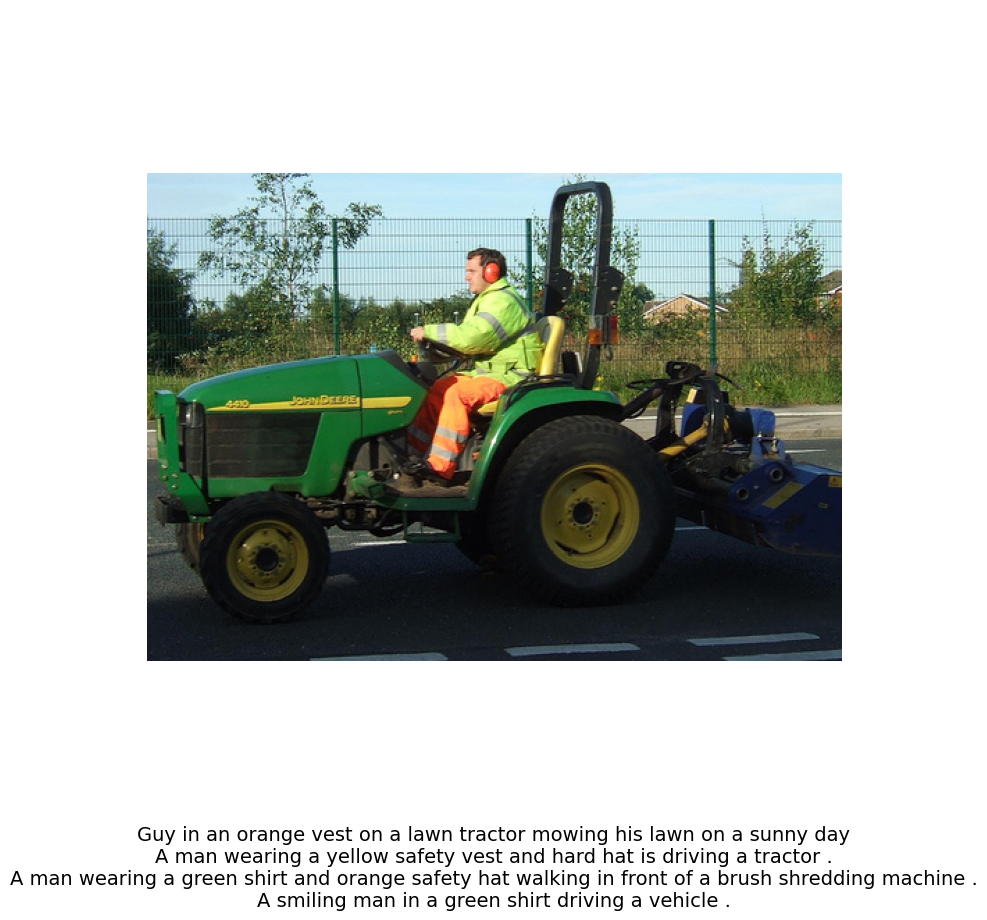

In [10]:
display_image_captions("static/test3.jpg")

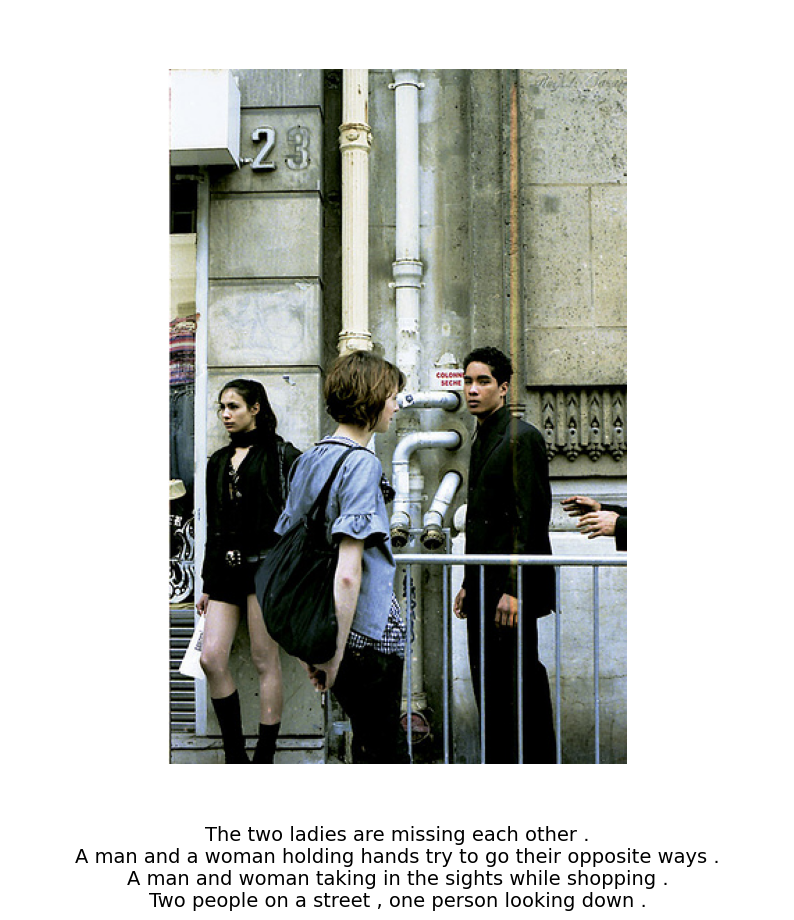

In [11]:
display_image_captions("static/test1.jpg")